# **Semantic Search Engine**
  Yavuz AKIN

  Last edition : 29 / 11 / 2020 22:24

---

# Summary

1.   Introduction
2.   References
3.   Importing Libraries and Preprocessing Data
4. Construction of the Pipeline and Text Embedding process
5. Construction of the Approximate Nearest Neighbour Index
6. Making the search
7. Interpretation, Comment, Analyze of Results
8. Going Further
9. Conclusion









# Introduction

Hi! In this Jupyter Notebook, I will try to implement a semantic search engine using text embeddings. Thanks to this format, I will be able to guide you through the code, explain the choices made, comment the code and analyze the results. 

At the end of the project, this search engine will be able to take into argument search queries, and find the messages that are the most related to these searches inside a given database. 

In order to build this search engine we will implement a pipeline with Apache Beam in which we will process the embedding of the words in the database (for the embedding we will use a module from TF-Hub). Then we will use Spotify's ANNOY module to find the nearest phrases to a given embedding thanks to the approximate nearest neighbours index.

If you want to directly test the code you just have to run all and then go to section *Making the search* where you can write your search query.



---


# References


*   [Tensorflow tutorials](https://www.tensorflow.org/tutorials) (especially the ones on semantic search were really useful, but also text embedding, and TF-Hub)
*   [Kaggle Courses and Community](https://https://www.kaggle.com/learn/natural-language-processing) (helpful to understand how word embeddings work and have examples)
* [Trey Grainger's lecture on how to build a semantic search system](https://www.youtube.com/watch?v=4fMZnunTRF8) (useful for understanding but not for the tools used)





---


# Importing libraries and preprocessing the Data 

OK! So first of all, we will install and import all the libraries we're going to use.

**NOTE : If you are executing this code through Google Colab, when the code is executed for the first time, it happens that errors occur during the pip install process, please restart the runtime after executing the codeline below to solve these errors (Runtime>Restart Runtime and Run All).**

In [ ]:
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow_hub==0.9.0
!pip install -q tensorflow_transform==0.24.1
# we choose this version of tf_transform while apache beam 2.24.0 doesn't work with higher
!pip install -q apache_beam==2.24.0
#we choose this version of apache beam while the new doesn't have features we use
!pip install -q sklearn
!pip install -q annoy





# ATTENTION : if there is an error here when executing wait for the execution to finish 
#              then go to Runtime>Restart Runtime and Run All









In [ ]:

import tensorflow.compat.v1 as tf # we use the first version of tensorflow
import tensorflow_transform as tft
import tensorflow_hub as hub
import tensorflow_transform.beam as tft_beam

import os
import sys
import pathlib
import pickle
from collections import namedtuple
from datetime import datetime

import numpy as np
import apache_beam as beam
import annoy
import itertools
import tempfile
import zipfile
import csv
import urllib.request
import matplotlib
import matplotlib.pyplot as plt

Then we download the database and process it in order to use it. The dataset we use is taken from the Kaggle website. It is a small database of Slack messages, or to be more precise Slack help requests. The first column contains the identification numbers, the second one the messages. We will only use the second column.

In [ ]:
!pwd

print('Beginning file download with urllib2...')

url = 'https://filesender.renater.fr/download.php?token=4bbcbaf7-e6db-4f8b-bb0d-9882b62886e8&archive_format=undefined&files_ids=3468821'
urllib.request.urlretrieve(url, 'archive.zip')

print("download completed \n")


# we unzip the document
with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall()


!rm -r data
!rm -r index.mapping
!rm -r index
!rm -r sample_data
!rm -r {output_dir}
!rm -r {temporary_dir}

!mkdir data #the directory in which we will put our data
!ls

#we put the data in a txt file and process it in the same (removing commas, \t, ...)
print ('\n')
with open('data/text.txt', 'w') as out_file:
  with open('messages.csv', 'r') as in_file:
    reader=csv.reader(in_file)
    i=0
    for line in reader:
      if i==0:
        i=i+1
      else:
        write=line[1].strip().replace('"','').replace(',','').replace('.','').replace('\n','').replace('\t','')
        out_file.write(write+"\n")

/content
Beginning file download with urllib2...
download completed 

rm: cannot remove 'index.mapping': No such file or directory
rm: cannot remove 'index': No such file or directory
rm: cannot remove 'sample_data': No such file or directory
rm: cannot remove '{output_dir}': No such file or directory
rm: cannot remove '{temporary_dir}': No such file or directory
archive.zip  data  messages.csv




In [ ]:
print("Here is an example of how the data is at the end : \n ")
!head data/text.txt

Here is an example of how the data is at the end : 
 
@daffl I just found a way of how to do it!
Hello guys Please I’m having an issue implementing a double authentication (if I’m permitted to call it that) on my feathers app The issue is I have a user model and also a worker model in which they both contain a unique email field So when logging in if the client specifies worker: true in the request body I want it to lookup the worker table and not the default user table I have tried a lot of methods to bypass this the simplest of which is having a beforeHook for my authentication endpoint:if (hookdataworker) {    let config = hookappget('authentication');    configservice = 'worker';    configlocalservice = 'worker';    hookappset('authentication' config);    return hook;}But I noticed this didn’t change anything probably because appconfigure(authentication) has auto-configured the app to lookup the user table the first time the server is lifted Please how do I go about this? I have do



---


# Construction of the Pipeline and Text Embedding process
As said before, the pipeline is constructed in order to process the data from our database into something we can work with.

The module we will use for text embedding is the Universal Sentence Encoder. This module can be found already trained in TF-Hub (https://tfhub.dev/google/universal-sentence-encoder/2).

*The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks. The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs.(Tensorflow-Hub, Universal Sentence Encoder Documentation)*

That's why this module works in our case, since messages are short sentences or paragraphes.

In [ ]:
link_module = 'https://tfhub.dev/google/universal-sentence-encoder/2'

The following function is used for embedding the texts from messages.txt inside the Beam pipeline.

In [ ]:
encoder = None

def embedding_text(text, link_module):
  global encoder
  if not encoder:
    encoder = hub.Module(link_module)
  embedding = encoder(text)
  return embedding

The following function is used for calculating the embeddings of the search queries we make at the end of the project (not inside the pipeline, I tried to put it inside the pipeline but it didn't worked). 
It loads the module we took from TF-Hub. It also creates a session for executing the graph and its operations.


In [ ]:
def module_loading(link_module):
  placeholder = tf.placeholder(dtype=tf.string) #placeholder is used to feed actual training examples, here strings
  embedding_module = hub.Module(link_module) #loads the module for embedding
  embedding = embedding_module(placeholder) #the type of data with which the module will be feeded
  session = tf.Session() #la session initialise le graphe et les opérations sur le tensor
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])

  def embeddings_fn(sentences):
    computed_embeddings = session.run(
        embedding, feed_dict={placeholder: sentences})
    return computed_embeddings

  return embeddings_fn #la fonction renvoit une autre fonction pour le embedding

print("Loading the TF-Hub module...")
g = tf.Graph()
with g.as_default():
  embedding_fn = module_loading('https://tfhub.dev/google/universal-sentence-encoder/2')
print("TF-Hub module is loaded.")

g = tf.Graph()
with g.as_default():
  original_dim = module_loading(link_module)(['']).shape[1]

Loading the TF-Hub module...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TF-Hub module is loaded.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
g = tf.Graph()
with g.as_default():
  original_dim = module_loading(link_module)(['']).shape[1]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Next, we must implement a preprocessing function. It is the most important concept of tf.Transform. It modifies the input features to adapt the data as it is needed. In this case, it calculates the embedding of each text (by calling embedding_text). It must return a tensor (the features are the text and its embedding). The preprocessor is inside a preprocessor maker.

In [ ]:
def preprocess_fn_maker(link_module):

  def _preprocess_fn(input_features):
    text = input_features['text']
    # Generate the embedding for the input text
    embedding = embedding_text(text, link_module)
    output_features = {
        'text': text, 
        'embedding': embedding
        }
    return output_features

  return _preprocess_fn

The function below helps us create metadata. [Metadata](https://www.tensorflow.org/tfx/tutorials/transform/simple) organizes information about the pipeline and makes it easier to retrieve information.

In [ ]:
def create_raw_metadata():
  from tensorflow_transform.tf_metadata import dataset_metadata
  from tensorflow_transform.tf_metadata import schema_utils
  f_spec = {'text': tf.FixedLenFeature([], dtype=tf.string)}
  data_schema = schema_utils.schema_from_feature_spec(f_spec)
  metadata = dataset_metadata.DatasetMetadata(data_schema)
  return metadata

The function below is the one that creates the Beam pipeline for Text Embedding. First of all, it reads the sentences from the input file. Then by using the preprocessing function it calculates the embedding of the text. Finally it stocks the embedded into TFRecords file. 

[TFRecords](https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564) is Tensorflow's own binary storage format. It is optimized for Tensorflow and it's quick to process since it is in binary.

In [ ]:
def from_hub_to_text_embedding(args):

  options = beam.options.pipeline_options.PipelineOptions(**args)# the options for the beam pipeline are loaded
  args = namedtuple("options", args.keys())(*args.values()) #namedtuple creates tuple subclasses

  raw_metadata = create_raw_metadata()#we create a schema of raw metadata
  converter = tft.coders.CsvCoder(
      column_names=['text'], schema=raw_metadata.schema)

  with beam.Pipeline(args.runner, options=options) as pipeline: #creation de la pipeline
    with tft_beam.Context(args.temporary_dir): #The temporary directory used within in this block.
      sentences = ( 
          pipeline
          | 'Read sentences from files' >> beam.io.ReadFromText( # first action is to read the text
              file_pattern=args.data_dir)
          | 'Convert to dictionary' >> beam.Map(converter.decode) # convert it to a dictionnary
      )

      sentences_dataset = (sentences, raw_metadata) 
      preprocess_fn = preprocess_fn_maker(args.link_module) #we create the preprocess function for the data
      # Generate the embeddings for the sentence using the TF-Hub module
      embeddings_dataset, _ = (
          sentences_dataset
          | 'Extract embeddings' >> tft_beam.AnalyzeAndTransformDataset(preprocess_fn)
      )

      embeddings, transformed_metadata = embeddings_dataset
       # Write the embeddings to TFRecords files
      embeddings | 'Write embeddings to TFRecords' >> beam.io.tfrecordio.WriteToTFRecord(
          file_path_prefix='{}/emb'.format(args.output_dir),#we put the results in an TFr output file
          file_name_suffix='.tfrecords',
          coder=tft.coders.ExampleProtoCoder(transformed_metadata.schema))

Then we define the arguments that we will enter in the pipeline. It is intereseting to see that we will use batches for this pipeline but we could also process the data by streaming since Apache Beam can do both.

In [ ]:
#we create the temporary directories we're going to use in our code
output_dir = pathlib.Path(tempfile.mkdtemp())
temporary_dir = pathlib.Path(tempfile.mkdtemp())

!rm -r {output_dir}
!rm -r {temporary_dir}


#here are the arguments for creating our pipeline
arguments = {
    'job_name': 'from_hub_to_emb-{}'.format(datetime.utcnow().strftime('%y%m%d-%H%M%S')),
    'runner': 'DirectRunner',
    'batch_size': 1024,
    'data_dir': 'data/*.txt',
    'output_dir': output_dir,
    'temporary_dir': temporary_dir,
    'link_module': link_module,
}

print("Pipeline args are set.")
arguments

Pipeline args are set.


{'batch_size': 1024,
 'data_dir': 'data/*.txt',
 'job_name': 'from_hub_to_emb-201216-184610',
 'link_module': 'https://tfhub.dev/google/universal-sentence-encoder/2',
 'output_dir': PosixPath('/tmp/tmp7j0unt6w'),
 'runner': 'DirectRunner',
 'temporary_dir': PosixPath('/tmp/tmpmkcp9ln8')}

In [ ]:
print("Running pipeline...")
from_hub_to_text_embedding(arguments)
print("Pipeline is done.")

Running pipeline...


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/tmpmkcp9ln8/tftransform_tmp/24803e1eddea4b1891d1a95d69e4f9e5/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/tmpmkcp9ln8/tftransform_tmp/24803e1eddea4b1891d1a95d69e4f9e5/saved_model.pb


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


Pipeline is done.


Here is the name of our output file :

In [ ]:
!ls {output_dir}

emb-00000-of-00001.tfrecords


In the following lines you can find examples of sentences with their embedding :

In [ ]:


embed_file = os.path.join(output_dir, 'emb-00000-of-00001.tfrecords') # we find the path to the file
sample = 3  
record_iterator =  tf.io.tf_record_iterator(path=embed_file) # the iterator reads the content of the TFRecord file
for string_record in itertools.islice(record_iterator, sample):
  example = tf.train.Example() #example will contain the texts
  example.ParseFromString(string_record) #strings are loaded into example in binary format
  text = example.features.feature['text'].bytes_list.value
  embedding = np.array(example.features.feature['embedding'].float_list.value)
  print("Embedding dimensions: {}".format(embedding.shape[0]))
  print("{}: {}".format(text, embedding[:10]))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Embedding dimensions: 512
[b'@daffl I just found a way of how to do it!']: [ 0.02169154  0.03772305 -0.04346156  0.03087032  0.00793623  0.08710686
 -0.07723573 -0.05725513  0.00376724  0.04280794]
Embedding dimensions: 512
[b"Hello guys Please I\xe2\x80\x99m having an issue implementing a double authentication (if I\xe2\x80\x99m permitted to call it that) on my feathers app The issue is I have a user model and also a worker model in which they both contain a unique email field So when logging in if the client specifies worker: true in the request body I want it to lookup the worker table and not the default user table I have tried a lot of methods to bypass this the simplest of which is having a beforeHook for my authentication endpoint:if (hookdataworker) {    let config = hookappget('authentication');    configservice = 'worker';    configlocalservice = 'worker';    hookappset('authentication' config);    return hook;}But I noticed this didn\xe2\x80\x99t change anything probably bec



---


# Construction of the Approximate Nearest Neighbour Index

Text embeddings can be seen as volumes in a graph. A great example for visualizing this concept is the [Tensorflow Embedding Projector](https://projector.tensorflow.org/). The more the embeddings are near in the graph the more they are similar in a semantic way. So in order to find the most similar messages to our query we must find the embeddings that are the nearest to the one of our query. 

In order to find those embeddings, we will use ANNOY (Approximate Nearest Neighbour Oh Yeah) which is a library created by Spotify normally made for finding the music that suits us best. Here we will use in the case of Text Embeddings.

That's why we'll build an index that will help us find the nearest embeddings to our query :



In [ ]:
def build_index(embedding_files_pattern, index_filename, vector_length, 
    metric='angular', num_trees=100):

  annoy_index = annoy.AnnoyIndex(vector_length, metric=metric) #we create the index
  # Mapping between the item and its identifier in the index
  mapping = {} # the mapping will help us find which embedding belongs to which text

  embed_file = tf.gfile.Glob(embedding_files_pattern) #returns the file that matches the pattern given to arg
  print('Found the embedding file.')

  item_counter = 0
  embedded_file=embed_file[0]
  print("Loading embedding file")
  record_iterator = tf.io.tf_record_iterator(path=embedded_file) #load file into iterator for reading TFRecord files

#as in the cube before we read the lines of the TFRecord file
  for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    text = example.features.feature['text'].bytes_list.value[0].decode("utf-8")
    mapping[item_counter] = text #we add the text to the mapping so that we can find him with his embedding
    embedding = np.array(example.features.feature['embedding'].float_list.value)
    annoy_index.add_item(item_counter, embedding) #we add the embedding to the ANNOY index
    item_counter += 1

  print('A total of {} items added to the index'.format(item_counter))

  annoy_index.build(n_trees=num_trees) #the number of trees used affects the accuracy of the index but also its running time
  print('Index is built.')
  
  annoy_index.save(index_filename) # we save the file into our directory
  print('Index is saved to disk.')
  
  with open(index_filename + '.mapping', 'wb') as handle: #we use pickle to create the mapping file and put the mapping
    pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)# ... elements in it
  print('Mapping is saved to disk.')

Now we can build the index : 

In [ ]:
embedding_files = "{}/emb-*.tfrecords".format(output_dir)
embedding_dimension = original_dim  #Faire gaffe ici ca pourrait être le projeté avec un RR
index_filename = "index"

!rm {index_filename}
!rm {index_filename}.mapping

build_index(embedding_files, index_filename, embedding_dimension)

rm: cannot remove 'index': No such file or directory
rm: cannot remove 'index.mapping': No such file or directory
Found the embedding file.
Loading embedding file
A total of 1566 items added to the index
Index is built.
Index is saved to disk.
Mapping is saved to disk.


Here is our directory now :

In [ ]:
!ls

archive.zip  data  index  index.mapping  messages.csv


In [ ]:
index = annoy.AnnoyIndex(embedding_dimension)
index.load(index_filename, prefault=True) #we load the index we built
print('Annoy index is loaded.')
with open(index_filename + '.mapping', 'rb') as handle:
  mapping = pickle.load(handle) # we load the mapping
print('Mapping file is loaded.')

Annoy index is loaded.
Mapping file is loaded.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """Entry point for launching an IPython kernel.


Now we will write a function, for finding similar embeddings to a given embeddinng thanks to the index we've built :

In [ ]:
def find_similar_items(embedding, num_matches):
  ids,distances = index.get_nns_by_vector(embedding, num_matches, search_k=-1, # this function finds the nearest embeddings 
    include_distances=True) 
  items = [mapping[i] for i in ids] #we find the texts that correspond to these embeddings
  return items,distances

---
# Making the search

 **Finally, here is the part where you can write the query, which means in the context of our data the messages you are looking for :**

In [ ]:
query = "How can I make the client work ?"

In [ ]:
print("Generating embedding for the query...")
%time query_embedding = embedding_fn([query])[0]
print("embedding for the query is created")
print("")
print("Finding relevant items in the index...")

#You must choose the number of similar texts you want to see
number_of_texts =10

%time items,distances = find_similar_items(query_embedding, number_of_texts)



Generating embedding for the query...
CPU times: user 195 ms, sys: 20.2 ms, total: 215 ms
Wall time: 220 ms
embedding for the query is created

Finding relevant items in the index...
CPU times: user 1.08 ms, sys: 153 µs, total: 1.24 ms
Wall time: 747 µs


**So here are the results :**

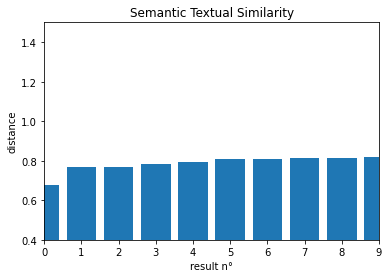

In [ ]:
%matplotlib inline
x = np.arange(0, number_of_texts, 1)
y = distances

plt.axis([0,number_of_texts-1,0.4,1.5])
plt.bar(x, y)
plt.title('Semantic Textual Similarity')
plt.xlabel('result n°')
plt.ylabel('distance')
plt.show()

In [ ]:

print("Results:")
for i in range(len(items)):
  print('\n')
  print('result n°:'+str(i))
  print(items[i])
  print('distance:')
  print(distances[i])

Results:


result n°:0
i think i already asked once but how do i get the client ip in a service method?
distance:
0.6761187314987183


result n°:1
I’m trying to do this from client
distance:
0.767525315284729


result n°:2
how do I send an error to client ?
distance:
0.769229531288147


result n°:3
i guess i was trying to restrict what the client can do
distance:
0.7827509641647339


result n°:4
can I list from the client the services that are available?
distance:
0.7924641966819763


result n°:5
Hey guys how do I ignore a service event on the client that originated it?
distance:
0.8079362511634827


result n°:6
So the problem I'm trying to solve: How to authenticate the user without using the feathers client?
distance:
0.8097811937332153


result n°:7
How can I merge client calls ?
distance:
0.8154478073120117


result n°:8
How can I merge client calls ?
distance:
0.8154478073120117


result n°:9
I am trying to build a preview for email templates and I am stuck All of Email building i



---
# Intrepretation, Comment, Analyze of Results

First of all, the model seems to work correctly, for the many searches I made, the closest messages I received were most of the time related to the query. 

The model is indeed semantic since some results I had didn't contain any of the keywords in the search query I made. 

The distances between the search query and the results range between 0.5 and 1.Which is acceptable but not good enough. Other semantic search engines are able to find messages with 0.3 or 0.4 distances.  

I believe the absence of accuracy is not related to the model but the dataset I chose. A Data Scientist must always analyze its data before processing it. 

The dataset I chose is a typical inbox of someone's help requests on Slack. But it isn't big enough (a few more than 1500 messages). That's why it is complicated to find messages similar to my search query while there so few data to look into. With a bigger dataset the model could be able to find better messages, because there are more options.






---
# Going Further


**Regarding the bonus task of highlighting the relevant words in a similar message, I coudn't find enough information on the matter to provide a solution. Perhaps we need to look at the embeddings not as a sentence but as words so that we can find the words that are the most relevant inside the sentence. But then the computation time could be really high so.**


---



Eventhough the processing in the pipeline and the construction of the index was quite fast in this example. With a bigger dataset the calculations would be much more longer. Users would not want to wait more than a minute to have results to their search queries. That is why we could perhaps consider loosing in accuracy in the sake gaining processing time. 

One solution to this problem could that we use a Random Projection Weight Matrix. Random Projection could allow us to reduce the dimension of the embeddings which reduce the computation time needed in our programm (even though we would lose in accuracy).

When doing research I also saw a lot documentation on a semantic search engine based on Sentence BERT. Perhaps this model could be more interesting than the one we've implemented.




---

# Conclusion

To conclude, the model we've built seems to work fine, even though the dataset I chose seems poor, and the computation time can be really high with bigger datasets.

Regarding the bonus task of highlighting the relevant words in a similar message, I coudn't find enough information on the matter to provide a solution. Perhaps we need to look at the embeddings not as a sentence but as words so that we can the words that are the most relevant inside the sentence.

In the making of this project I have learned a lot of new things. I already had experience with Text Embeddings using the SpaCy library but it is the first I used Tensorflow on this subject. Tensorflow is really well documented and the tutorials related to it are really well constructed. Thanks to them and the forums, I have been able to accomplish this project and learn a lot of stuff !

There are still some things I have difficulties with such as how does metadata work or some codes that I have tried and coudn't understand why they didn't work, I will try to document myself on these subjects.

I thank the readers for following until here. 

Best Regards, 

Yavuz AKIN.